In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy import signal
import gc

In [2]:
batch1 = pickle.load(open(r'batch1.pkl', 'rb'))
numBat1 = len(batch1.keys())
batch2 = pickle.load(open(r'batch2.pkl','rb'))
numBat2 = len(batch2.keys())
batch3 = pickle.load(open(r'batch3.pkl','rb'))
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}
bat_dict_keys = bat_dict.keys()
bat_dict_keys

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c7', 'b2c8', 'b2c9', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c15', 'b2c16', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c2', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b

In [3]:
I=[]
V=[]
T=[]
SOH=[]
charge_policy=[]
Time=[]
qc=[]
qd=[]
ce=[]
for i in bat_dict_keys:
    clear_output(wait=True)
    print('cell:', i)
    cell=bat_dict[i]
    num_cycle=len(cell['summary']['cycle'])
    for j in range(1,num_cycle):
        I.append(cell['cycles'][str(j)]['I'])
        V.append(cell['cycles'][str(j)]['V'])
        T.append(cell['cycles'][str(j)]['T'])
        Time.append(cell['cycles'][str(j)]['t'])
        charge_policy.append(cell['charge_policy'])  
        QC = cell['summary']['QC'][j]
        QD = cell['summary']['QD'][j]
        qd.append(QD)
        qc.append(QC)
        initial_Qd=cell['summary']['QD'][1]
        SOH.append((QD)/initial_Qd)
        dict_key = "{}_cycle_{}".format(i,j)
        ce.append(dict_key)
print('all cycles from batches 1, 2 and 3 were browsed')

cell: b3c45
all cycles from batches 1, 2 and 3 were browsed


In [4]:
df=pd.DataFrame({"Time":Time,"I":I,"V":V,"T":T,"charge_policy":charge_policy,"Qc":qc,"Qd":qd,"SOH":SOH})

In [5]:
df.index=ce

In [6]:
cycle_dataset_df=df.T

In [7]:
cycle_dataset_df=cycle_dataset_df.T

In [8]:
cycle_dataset_df=cycle_dataset_df.T

In [9]:
cells=[]
k=["1","2","3"]
for j in k:
    for i in range(48):
      filter_col=[]
      data=[]
      filter_col = [col for col in cycle_dataset_df if col.startswith("b"+j+"c"+str(i)+"_cycle")]
      data=cycle_dataset_df[filter_col].T
      data=data.reset_index(drop=True)
      if (len(data)>0):
            cells.append(data)

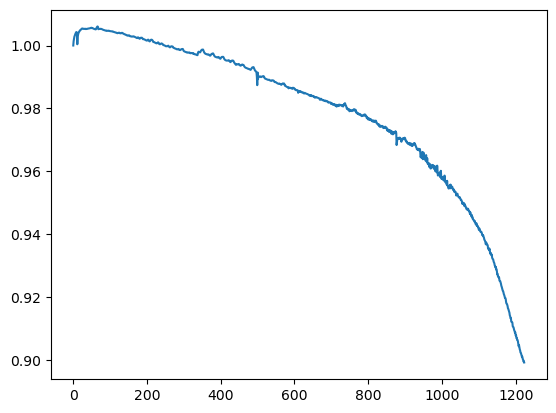

In [10]:
plt.plot(cells[3]["SOH"])

In [11]:
for i in range(len(cells)):
    cells[i]["SOH"]=signal.savgol_filter(cells[i]["SOH"] , 90, 2)

In [12]:
cells=cells[1:]

In [13]:
len(cells)

139

In [14]:
num_cycles=[]
for i in range(len(cells)):
    num_cycles.append(len(cells[i]))

In [15]:
np.max(num_cycles)

2236

### Shuffle batteries

In [16]:
import random
random.shuffle(cells)

### Split data 

In [17]:
size=int(0.6*len(cells)) # to be changed to 80%
train_data=cells[0:size] 
test_data=cells[size:] 

In [16]:
def normalization(train_data,test_data,inputsetp):
    mini=np.min(train_data[0][0][0])
    minv=np.min(train_data[0][0][1])
    mint=np.min(train_data[0][0][2])
    maxi=np.max(train_data[0][0][0])
    maxv=np.max(train_data[0][0][1])
    maxt=np.max(train_data[0][0][2])
   
    for i in range(len(train_data)):
        for j in range(inputsetp):
                maxi=np.max([np.max(train_data[i][j][0]),maxi])
                mini=np.min([np.min(train_data[i][j][0]),mini])
                
                maxv=np.max([np.max(train_data[i][j][1]),maxv])
                minv=np.min([np.min(train_data[i][j][1]),minv])
                
                maxt=np.max([np.max(train_data[i][j][2]),maxt])
                mint=np.min([np.min(train_data[i][j][2]),mint])
    cycle_dataset_df=train_data        
    for i in range(len(cycle_dataset_df)):
         for j in range(inputsetp):
                cycle_dataset_df[i][j][0]=(cycle_dataset_df[i][j][0]-mini)/(maxi-mini)
                cycle_dataset_df[i][j][1]=(cycle_dataset_df[i][j][1]-minv)/(maxv-minv)
                cycle_dataset_df[i][j][2]=(cycle_dataset_df[i][j][2]-mint)/(maxt-mint)
    train_data=np.copy(cycle_dataset_df)
    cycle_dataset_df=test_data
    for i in range(len(cycle_dataset_df)):
         for j in range(inputsetp):
                cycle_dataset_df[i][j][0]=(cycle_dataset_df[i][j][0]-mini)/(maxi-mini)
                cycle_dataset_df[i][j][1]=(cycle_dataset_df[i][j][1]-minv)/(maxv-minv)
                cycle_dataset_df[i][j][2]=(cycle_dataset_df[i][j][2]-mint)/(maxt-mint)
    
    test_data=np.copy(cycle_dataset_df)
    min_max=[mini,maxi,minv,maxv,mint,maxt]
    return train_data,test_data,min_max

In [17]:
def normalization2(train_data,inputsetp,min_max):
    mini=min_max[0]
    minv=min_max[2]
    mint=min_max[4]
    maxi=min_max[1]
    maxv=min_max[3]
    maxt=min_max[5]
   
    cycle_dataset_df=train_data        
    for i in range(len(cycle_dataset_df)):
         for j in range(inputsetp):
                cycle_dataset_df[i][j][0]=(cycle_dataset_df[i][j][0]-mini)/(maxi-mini)
                cycle_dataset_df[i][j][1]=(cycle_dataset_df[i][j][1]-minv)/(maxv-minv)
                cycle_dataset_df[i][j][2]=(cycle_dataset_df[i][j][2]-mint)/(maxt-mint)
    train_data=np.copy(cycle_dataset_df)
    return train_data

In [20]:
X1=[]
X2=[]
for i in range(len(train_data)):
      X1.append(train_data[i].drop(["SOH","charge_policy","Qc","Qd","Time"],axis=1).to_numpy())

for i in range(len(test_data)):
      X2.append(test_data[i].drop(["SOH","charge_policy","Qc","Qd","Time"],axis=1).to_numpy())


In [21]:
Y1=[]
Y2=[]
for i in range(len(train_data)):
      Y1.append(train_data[i]["SOH"].to_numpy())
for i in range(len(test_data)):
      Y2.append(test_data[i]["SOH"].to_numpy())



In [22]:
max1=[]
for i in range(len(X1)):
    for j in range(len(X1[i])):
        max1.append(len(X1[i][j][0]))
    

In [23]:
np.mean(max1) # 974.006 average length of a feature with std of 621

954.0286853053268

In [24]:
max2=[]
cycle_num=0
for i in range(len(Y1)):
        cycle_num+=len(Y1[i])
        max2.append(len(Y1[i]))
    

In [25]:
cycle_num

68746

In [26]:
np.max(max2) ## max number of cycles found for a cell

2236

In [27]:
len(max2)

83

In [28]:
x=[]
for i in range(len(X1)):
    t=np.zeros((len(X1[i]),3,1000))
    for j in range(len(X1[i])):
        size=min(1000,len(X1[i][j][0]))
        for k in range(3):
            t[j][k][0:size]=X1[i][j][k][0:size]
    x.append(np.copy(t))

In [29]:
X1=x

In [30]:
x=[]
for i in range(len(X2)):
    t=np.zeros((len(X2[i]),3,1000))
    for j in range(len(X2[i])):
        size=min(1000,len(X2[i][j][0]))
        for k in range(3):
            t[j][k][0:size]=X2[i][j][k][0:size]
    x.append(np.copy(t))

In [31]:
X2=x

In [18]:
# split a univariate sequence into samples
def split_sequence(inputx,outputy,Xn,Yn,input_size):
    for i in range(len(Xn)):
        start_index=0
        end_index=input_size
        cellx=Xn[i]
        celly=Yn[i]
        while ((end_index-len(cellx))!=0):
            x,y=cellx[start_index:end_index],celly[end_index:len(celly)-1]
            if(len(y)>=10):
                inputx.append(x)
                outputy.append(y)
            else:
                break
            end_index=end_index+1
            start_index=start_index+1

In [19]:
def split_sequence2(Xn,Yn,input_size):
        inputx=[]
        outputy=[]
        start_index=0
        end_index=input_size
        cellx=Xn
        celly=Yn
        while ((end_index-len(cellx))!=0):
            x,y=cellx[start_index:end_index],celly[end_index:len(celly)-1]
            if(len(y)>=10):
                inputx.append(x)
                outputy.append(y)
            else:
                break
            end_index=end_index+input_size
            start_index=start_index+input_size
        return inputx,outputy

In [34]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
split_sequence(X_train,Y_train,X1,Y1,25)
split_sequence(X_test,Y_test,X2,Y2,25)

### padding 

In [35]:
max2=[]
for i in range(len(Y_train)):
        max2.append(len(Y_train[i]))

In [36]:
np.std(max2)

405.52013581153915

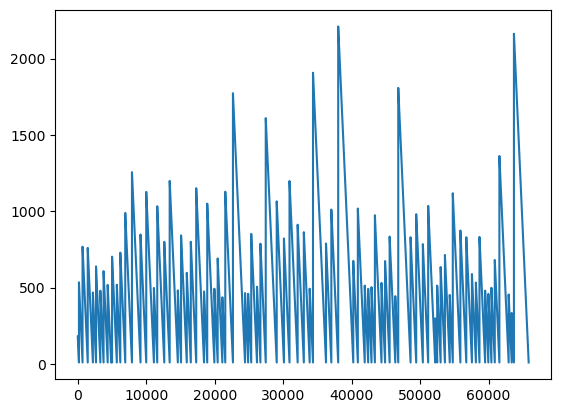

In [37]:
plt.plot(max2)


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
Y1=pad_sequences(Y_train,maxlen=2000,padding = 'post',dtype='float32')
Y2=pad_sequences(Y_test,maxlen=2000,padding = 'post',dtype='float32')

In [40]:
X1=np.float32(X_train)
Y1=np.float32(Y1)

X2=np.float32(X_test)
Y2=np.float32(Y2)

In [41]:
X1,X2,min_max=normalization(X1,X2,25)

In [42]:
min_max

[-12.213394, 8.02699, 0.0, 3.6423006, 0.0, 43.113594]

In [46]:
np.save("min_max_h",min_max)

### Encoding the data

In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_step=25
input_shape = (input_step,3,1000)
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
code_size = 64

input_layer = Input(shape=(input_shape))
print(input_layer)
hidden_layer_0=Flatten()(input_layer)
hidden_layer_1 = Dense(hidden_size1, activation='relu')(hidden_layer_0)
hidden_layer_2 = Dense(hidden_size2, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(hidden_size3, activation='relu')(hidden_layer_2)
bottleneck_layer = Dense(code_size*input_step, activation='sigmoid')(hidden_layer_3)

# Define the decoder network
hidden_layer_5 = Dense(hidden_size1, activation='relu')(bottleneck_layer)
hidden_layer_6 = Dense(hidden_size2, activation='relu')(hidden_layer_5)
hidden_layer_7 = Dense(hidden_size1, activation='relu')(hidden_layer_6)
hidden_layer_8 = Dense(3*1000*input_step, activation='sigmoid')(hidden_layer_7)
output_layer=Reshape((input_step,3,1000))(hidden_layer_8)

autoencoder = Model(input_layer, output_layer)
autoencoder.summary()
opt = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss='mae',metrics=['mae', 'mse',tf.keras.metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
autoencoder.fit(X1, X1, epochs=300,batch_size=64,
                validation_data=(X2, X2),callbacks=[early_stopping]
              )

In [45]:
from keras.models import Model
encoder = Model(input_layer, bottleneck_layer)
encoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
encoder.save("encoder-simple_hole2.h5")

In [46]:
decoder = Model(bottleneck_layer, output_layer)
decoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
decoder.save("decoder-simple_hole2.h5")

In [44]:
encoder=tf.keras.models.load_model("./Models/80-20-split/encoder-simple_hole2.h5")
decoder=tf.keras.models.load_model("./Models/80-20-split/decoder-simple_hole2.h5")

In [45]:
X11=encoder.predict(X1)
X22=encoder.predict(X2)

1335/1335 [==============================] - 26s 19ms/step


In [47]:
Y22=decoder.predict(X22[1:2])

1/1 [==============================] - 0s 406ms/step


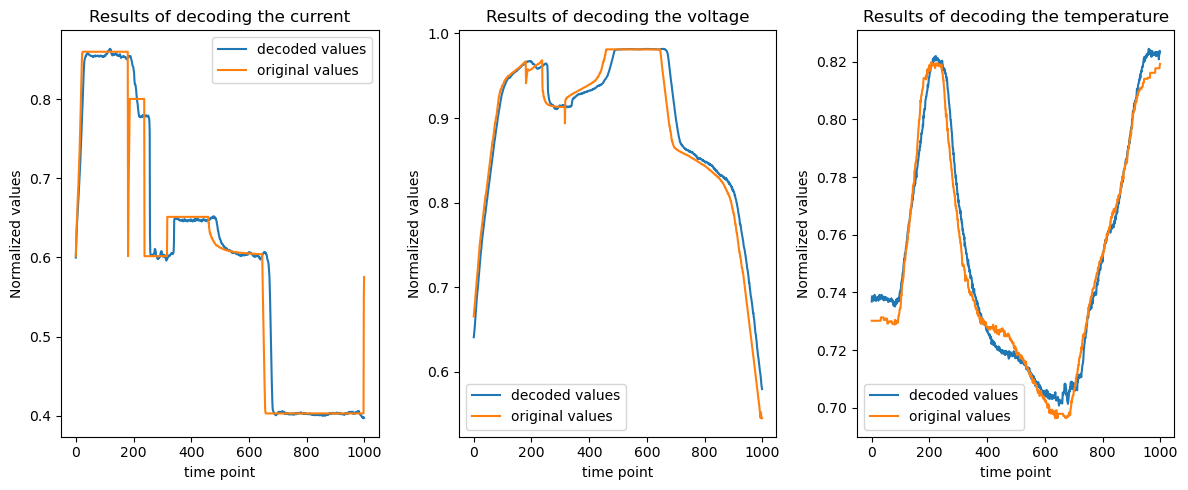

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

axes[0].plot(Y22[0][0][0],label="decoded values")
axes[0].plot(X2[0][0][0],label="original values")
axes[0].set_title("Results of decoding the current")

axes[1].plot(Y22[0][0][1],label="decoded values")
axes[1].plot(X2[0][0][1],label="original values")
axes[1].set_title("Results of decoding the voltage")

axes[2].plot(Y22[0][0][2],label="decoded values")
axes[2].plot(X2[0][0][2],label="original values")
axes[2].set_title("Results of decoding the temperature")

for ax in axes:
    ax.set_xlabel("time point")
    ax.set_ylabel("Normalized values")

# Display legend
for ax in axes:
    ax.legend()
plt.tight_layout()

#fig.savefig("docoded2.pdf", format="pdf", dpi=300,bbox_inches='tight')




In [48]:
np.shape(Y22)

(1, 25, 3, 1000)

In [46]:
X1=np.reshape(X11,(len(X11),25,64))
X2=np.reshape(X22,(len(X22),25,64)) #for the Tr models

In [43]:
X1=np.reshape(X1,(len(X1),25,3000))
X2=np.reshape(X2,(len(X2),25,3000)) #for the BiLSTM

In [44]:
from tensorflow.keras import regularizers
def model_comp():
    tf.keras.backend.set_epsilon(1e-9)
    cIntInputSeqLen=25
    cIntOutputSeqLen=2000
    cIntProcFeatures=3*1000
    cIntHiddenNode=64
    cIntMaskValue=0

    InputCap=tf.keras.layers.Input(shape=(cIntInputSeqLen,cIntProcFeatures))
    MaskedInputCap=tf.keras.layers.Masking(mask_value=cIntMaskValue)(InputCap)
    #encoder part
    EncCtext=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(MaskedInputCap)
    EncCtext=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(EncCtext)
    EncCtext=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(EncCtext)
    EncCtextOut=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=False))(EncCtext)
    CombCtext=tf.keras.layers.RepeatVector(cIntOutputSeqLen)(EncCtextOut)
    #decoder part for capacity
    Dec1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(CombCtext)
    Dec1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(Dec1)
    Dec1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(Dec1)
    Dec1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cIntHiddenNode,return_sequences=True))(Dec1)
    Dec1=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(cIntHiddenNode*2, activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))(Dec1)
    Dec1=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(cIntHiddenNode/2, activation="relu"))(Dec1)
    Dec1=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation="relu"))(Dec1)
    DecOutCap=tf.keras.layers.Flatten()(Dec1)
    model=tf.keras.Model(inputs=InputCap,outputs=DecOutCap)
    return model
model=model_comp()

## Building the model

In [21]:
def masked_mae_loss(y_true,y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    y_true = tf.cast(y_true, tf.float32)  # Cast to float32
    y_pred = tf.cast(y_pred, tf.float32)
    masked_error = tf.abs(y_true - y_pred) * mask
    masked_mae = tf.reduce_sum(masked_error) / tf.reduce_sum(mask)
    return masked_mae

In [22]:
def masked_mse_loss(y_true,y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    y_true = tf.cast(y_true, tf.float32)  # Cast to float32
    y_pred = tf.cast(y_pred, tf.float32)
    masked_error = tf.square(y_true - y_pred) * mask
    masked_mse = tf.reduce_sum(masked_error) / tf.reduce_sum(mask)
    return masked_mse


In [25]:
def masked_mape_loss(y_val,y_pred):
    mask = y_val != 0
    
    # Apply the mask to ignore zero-padded elements
    y_val_masked = y_val[mask]
    y_pred_masked = y_pred[mask]
    # Calculate MAPE with zero-padding consideration
    mape = np.mean(np.abs((y_val_masked - y_pred_masked) / y_val_masked)) * 100
    return mape

In [49]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)


        
  return tf.cast(pos_encoding, dtype=tf.float32)

# Define Transformer Model i version
def model1(input_shape, output_shape, num_heads=2, ff_dim=32, num_transformer_blocks=2, dropout_rate=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs + positional_encoding(input_shape[0], 64)[0]

    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        attn_output,attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=512)(x, x, return_attention_scores=True)
        x = tf.keras.layers.Add()([x, attn_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
        ffn_output = tf.keras.layers.Dense(64)(ffn_output)
        x = tf.keras.layers.Add()([x, ffn_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Output Layer
    x2=x
    x=tf.keras.layers.GlobalAveragePooling1D()(x)
    x= tf.keras.layers.Dropout(0.1)(x)
    outputs= tf.keras.layers.Dense(output_shape,activation='linear')(x)
    #outputs= tf.keras.layers.Dense(output_shape,activation='linear')(x3)

    # Define model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model
# Define Transformer Model io version
def model3(input_shape, output_shape, num_heads=2, ff_dim=32, num_transformer_blocks=2, dropout_rate=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs + positional_encoding(input_shape[0], 64)[0]

    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        attn_output,attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=512)(x, x, return_attention_scores=True)
        x = tf.keras.layers.Add()([x, attn_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
        ffn_output = tf.keras.layers.Dense(64)(ffn_output)
        x = tf.keras.layers.Add()([x, ffn_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Output Layer
    x2=x
    x=tf.keras.layers.GlobalAveragePooling1D()(x)
    x= tf.keras.layers.Dropout(0.1)(x)
    x= tf.keras.layers.Dense(output_shape,activation='linear')(x)
    x3=tf.keras.layers.Reshape((output_shape,1))(x)
    x3,attention_score=tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=512)(query=x3,
        key=x2,
        value=x2, return_attention_scores=True)
    outputs=tf.keras.layers.Flatten()(x3)
    #outputs= tf.keras.layers.Dense(output_shape,activation='linear')(x3)

    # Define model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model
# Define LSTM Model 
def model2(input_shape,output_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x=tf.keras.layers.LSTM(units=512, activation='tanh', return_sequences=False)(inputs)
    outputs=tf.keras.layers.Dense(units=output_shape, activation='linear')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model



# Define input and output shapes
input_shape = (25,64)
output_shape = 2000

# Create model
model = model2(input_shape, output_shape)
#model.summary()

In [50]:
XT=np.concatenate((X1,X2),axis=0)
YT=np.concatenate((Y1,Y2),axis=0)

In [51]:
np.shape(YT)

(108545, 2000)

In [ ]:
import time
import numpy as np
import gc
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Assuming these are defined in transformer.py
from transformer import Transformer, Estimator  

X = XT
y = YT  # your target variable

# Set up the k-fold cross-validation object
k = 5   # number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the results
val_mae = []
val_mse = []
val_mape = []
val_rmse = []
training_times = []
testing_times = []

# Loop over the k folds
for train_index, val_index in kf.split(X):
    # Convert numpy arrays to TensorFlow tensors
    train_index_tf = tf.convert_to_tensor(train_index, dtype=tf.int32)
    val_index_tf = tf.convert_to_tensor(val_index, dtype=tf.int32)
    
    # Split the data into training and validation sets using TensorFlow tensors
    X_train, y_train = tf.gather(X, train_index_tf), tf.gather(y, train_index_tf)
    X_val, y_val = tf.gather(X, val_index_tf), tf.gather(y, val_index_tf)
    #model=model1()
    #model=model2()
    model = model3((25,64),2000)
    #model=model_comp()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-4),
        loss=masked_mae_loss,
        metrics=[masked_mae_loss, masked_mse_loss],
        loss_weights=([1.0, 0.0])
    )
    
    # Training the model
    start_time = time.time()
    model.fit(X_train, y_train, epochs=1, verbose=1)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    
    # Evaluate the model on validation set
    start_time = time.time()
    loss, val_acc_mae, val_acc_mse = model.evaluate(X_val, y_val)
    end_time = time.time()
    testing_time = end_time - start_time
    testing_times.append(testing_time)
    
    # Predictions to calculate additional metrics
    y_pred = model.predict(X_val)
    
    # Create a mask to filter out zero-padded values
    mask = y_val != 0
    
    # Apply the mask to ignore zero-padded elements
    y_val_masked = y_val[mask]
    y_pred_masked = y_pred[mask]
    
    # Calculate metrics
    mae = mean_absolute_error(y_val_masked, y_pred_masked)
    mse = mean_squared_error(y_val_masked, y_pred_masked)
    rmse = np.sqrt(mse)
    
    # Calculate MAPE with zero-padding consideration
    mape = np.mean(np.abs((y_val_masked - y_pred_masked) / y_val_masked)) * 100
    
    # Store metrics
    val_mae.append(mae)
    val_mse.append(mse)
    val_rmse.append(rmse)
    val_mape.append(mape)
    
    print(f"Fold results: MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")
    
    # Clean up to avoid memory issues
    del X_train, y_train, X_val, y_val
    gc.collect()

# Print the mean and standard deviation of the validation metrics
print(f'Validation MAE: {np.mean(val_mae):.5f} ± {np.std(val_mae):.5f}')
print(f'Validation MSE: {np.mean(val_mse):.5f} ± {np.std(val_mse):.5f}')
print(f'Validation RMSE: {np.mean(val_rmse):.5f} ± {np.std(val_rmse):.5f}')
print(f'Validation MAPE: {np.mean(val_mape):.5f} ± {np.std(val_mape):.5f}')
print(f'Training time per fold: {np.mean(training_times):.5f} ± {np.std(training_times):.5f}')
print(f'Testing time per fold: {np.mean(testing_times):.5f} ± {np.std(testing_times):.5f}')


# Evaluating

In [32]:
def prepare_data(d,input_step,encoder=encoder):
    x=d.drop(["SOH","charge_policy","Qc","Qd","Time"],axis=1).to_numpy()
    y=d["SOH"].to_numpy()
    
    t=np.zeros((len(x),3,1000))
    for j in range(len(x)):
            size=min(1000,len(x[j][0]))
            for k in range(3):
                t[j][k][0:size]=x[j][k][0:size]
    
    x,y=split_sequence2(t,y,25)
    x=normalization2(x,input_step,min_max)
    x=np.float32(x)
    y=pad_sequences(y,maxlen=2000,padding = 'post',dtype='float32')
    y=np.float32(y)
    x=encoder.predict(x,verbose=0)
    x=np.reshape(x,(len(x),25,64))
    return x,y


In [27]:
def prepare_data_2(d,input_step):
    x=d.drop(["SOH","charge_policy","Qc","Qd","Time"],axis=1).to_numpy()
    y=d["SOH"].to_numpy()
    
    t=np.zeros((len(x),3,1000))
    for j in range(len(x)):
            size=min(1000,len(x[j][0]))
            for k in range(3):
                t[j][k][0:size]=x[j][k][0:size]
    
    x,y=split_sequence2(t,y,25)
    x=normalization2(x,input_step,min_max)
    x=np.float32(x)
    y=pad_sequences(y,maxlen=2000,padding = 'post',dtype='float32')
    y=np.float32(y)
    #x=np.reshape(x,(len(x),25,3000))
    return x,y

In [28]:
def rul(data, specific_value=0.8, threshold=0.001):
    nearby_values = []
    for i in range(len(data)):
        if abs(data[i] - specific_value) <= threshold:
            break
    return i




In [29]:
def remouve_pading(d,s,limits=0.00025):
    d1=savgol_filter(d,50,2)
    t=[]
    t.append(d1[0])
    for i in range(1,len(d1)):
        if (((d1[i]-d1[i-1])<=limits) and (d1[i]>=s)) :
            t.append(d1[i])
        else:
            break
    return t

In [30]:
min_max=np.load("min_max_h.npy")

In [36]:
encoder=tf.keras.models.load_model("./Models/80-20-split/encoder-simple_hole2.h5")
decoder=tf.keras.models.load_model("./Models/80-20-split/decoder-simple_hole2.h5")
encoder2=tf.keras.models.load_model("./Models/60-40-split/encoder-simple_hole3.h5")
model_transformer1=tf.keras.models.load_model("./Models/80-20-split/soh1_transformer1.h5",custom_objects={"masked_mae_loss":masked_mae_loss,"masked_mse_loss":masked_mse_loss})
model_transformer2=tf.keras.models.load_model("./Models/60-40-split/soh_transformer_withmha.h5",custom_objects={"masked_mae_loss":masked_mae_loss,"masked_mse_loss":masked_mse_loss})
model_lstm=tf.keras.models.load_model("./Models/80-20-split/soh1_lstm.h5",custom_objects={"masked_mae_loss":masked_mae_loss,"masked_mse_loss":masked_mse_loss})
model_bilstm=tf.keras.models.load_model("./Models/soh_estimation_blstm.h5",custom_objects={"masked_mae_loss":masked_mae_loss,"masked_mse_loss":masked_mse_loss})

In [33]:
c=100
x,y=prepare_data(cells[c],25)
x2,y2=prepare_data(cells[c],25,encoder=encoder2)

1/1 [==============================] - 0s 25ms/step


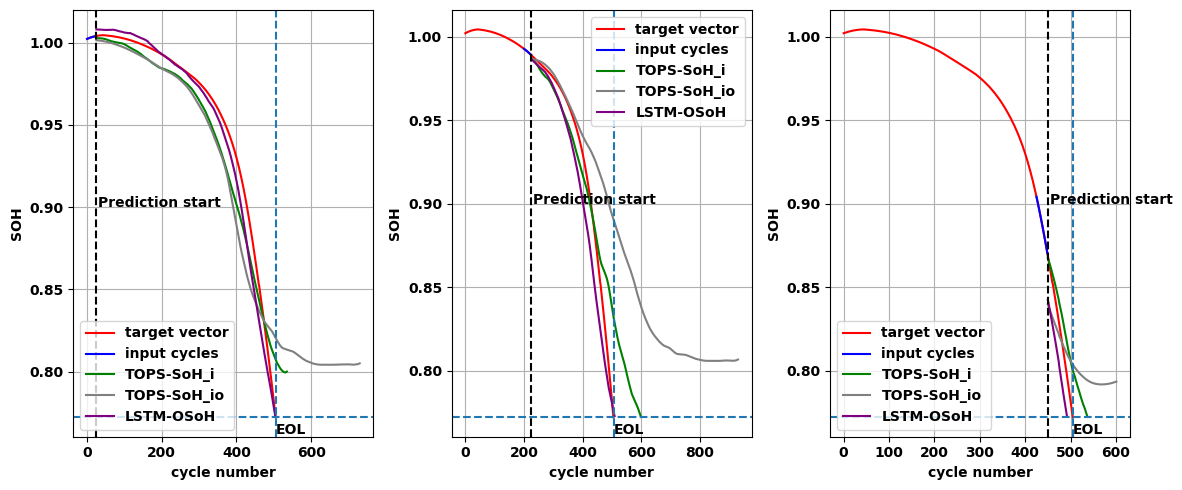

In [71]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
i = 0
j = 0
for i in [0, int(len(y) / 3)+2, len(y) - int(len(y) / 3)+4]:
    input_step = i * 25 + 25
    yp1 = model_transformer1.predict((np.reshape(x[i], (1, 25, 64))))[0]
    yp1 = remouve_pading(yp1,s=cells[c]["SOH"][len(cells[c]["SOH"]) - 1])
    
    yp2 = model_transformer2.predict((np.reshape(x2[i], (1, 25, 64))))[0]
    yp2 = remouve_pading(yp2,s=cells[c]["SOH"][len(cells[c]["SOH"]) - 1],limits=0.0001)
    
    yp3 = model_lstm.predict((np.reshape(x[i], (1, 25, 64))))[0]
    yp3 = remouve_pading(yp3,s=cells[c]["SOH"][len(cells[c]["SOH"]) - 1],limits=0.002)
    
    
    #ind=rul(yp, specific_value=cells[c]["SOH"][len(cells[c]["SOH"]) - 1]) 
    ax[j].plot(cells[c]["SOH"], color="red", label="target vector")
    index = range(input_step - 25, input_step)
    ax[j].plot(index, cells[c]["SOH"][input_step - 25:input_step], color='blue', label="input cycles")
    

    ax[j].plot(range(input_step, len(yp1) + input_step, 1), yp1, label="TOPS-SoH_i", color="green")
    ax[j].plot(range(input_step, len(yp2) + input_step, 1), yp2, label="TOPS-SoH_io", color="gray")
    ax[j].plot(range(input_step, len(yp3) + input_step, 1), yp3, label="LSTM-OSoH", color="purple")
    
    
    ax[j].axvline(x=input_step, color='black', linestyle='--')
    ax[j].axvline(x=len(cells[c]["SOH"]), linestyle='--')
    ax[j].axhline(y=cells[c]["SOH"][len(cells[c]["SOH"]) - 1], linestyle="--")
    ax[j].annotate('EOL', xy=(len(cells[c]["SOH"]), cells[c]["SOH"][len(cells[c]["SOH"]) - 1]), xytext=(len(cells[c]["SOH"]),cells[c]["SOH"][len(cells[c]["SOH"]) - 1]-0.01)
             ,color="black")
    ax[j].text(input_step + 5, 0.9, 'Prediction start', color="black")
    if (j==1):
        ax[j].legend(loc='upper right')
    else:
        ax[j].legend(loc='lower left')
        
    ax[j].grid()
    #ax[j].text(0, np.max(cells[c]["SOH"]) + 0.02,
               #"predicted RUL= " + str(ind) + ", true RUL= " + str(len(cells[c]["SOH"]) - input_step),
               #bbox=dict(facecolor='none'))
    ax[j].set_ylabel('SOH',weight="bold")  # Set x-label for each subplot
    ax[j].set_xlabel('cycle number',weight="bold")

   

    j += 1
#fig.suptitle('Model prediction for cell: '+list(bat_dict_keys)[c+1])
#fig.set
plt.tight_layout()  # Adjust layout to prevent overlap

fig.savefig("prediction-all-cell25.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot


In [34]:
model_transformer2.layers[20]  #model1:9, model2:20

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


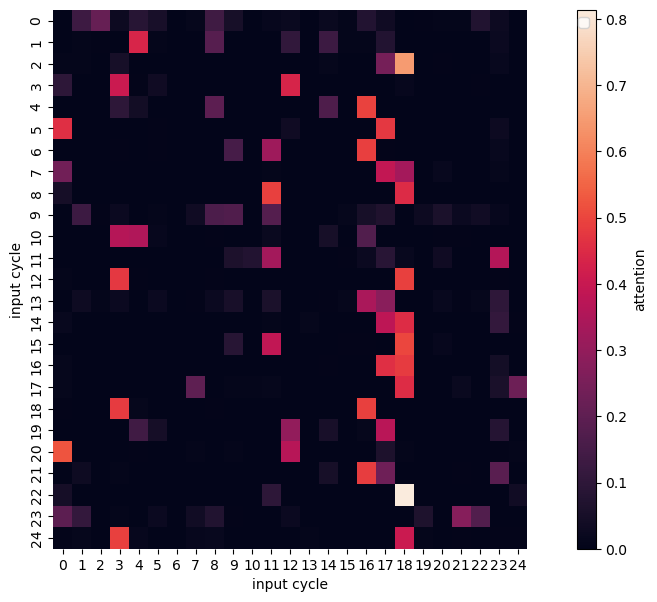

In [35]:
import seaborn as sb
attention_layer = model_transformer1.layers[9]
xp=np.reshape(x[0],(1,25,64))
#yp=np.reshape(model_transformer2.predict(xp)[0],(1,2000,1))

_, attention_scores = attention_layer(xp,xp,return_attention_scores=True) 
#_, attention_scores = attention_layer(query=yp,key=xp,value=xp,return_attention_scores=True)  # take one sample
arr=attention_scores[0][1]+attention_scores[0][0]
arr=arr/2
arr=arr[0:len(cells[c]["SOH"])]
scores=[np.argmax(arr[i]) for i in range(len(arr))]
fig, axs = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5, 0.2]), figsize=(7, 7))

sb.heatmap(arr, annot=False, cbar=False, ax=axs[0])
#sb.heatmap(arr, annot=False, yticklabels=False, cbar=False, ax=axs[1])
fig.colorbar(axs[0].collections[0], cax=axs[1])
axs[0].set_xlabel("input cycle")
axs[0].set_ylabel("input cycle")
plt.ylabel("attention")
plt.legend()
plt.show()
fig.savefig("attention.pdf", format="pdf", dpi=300,bbox_inches='tight')

In [35]:
decoded_v=decoder.predict(np.reshape(x[0],(1,1600)))

1/1 [==============================] - 0s 92ms/step


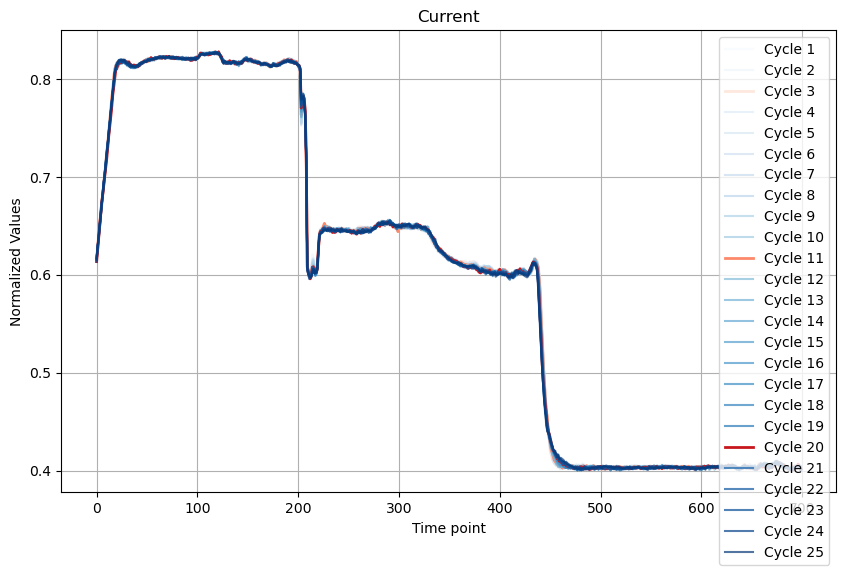

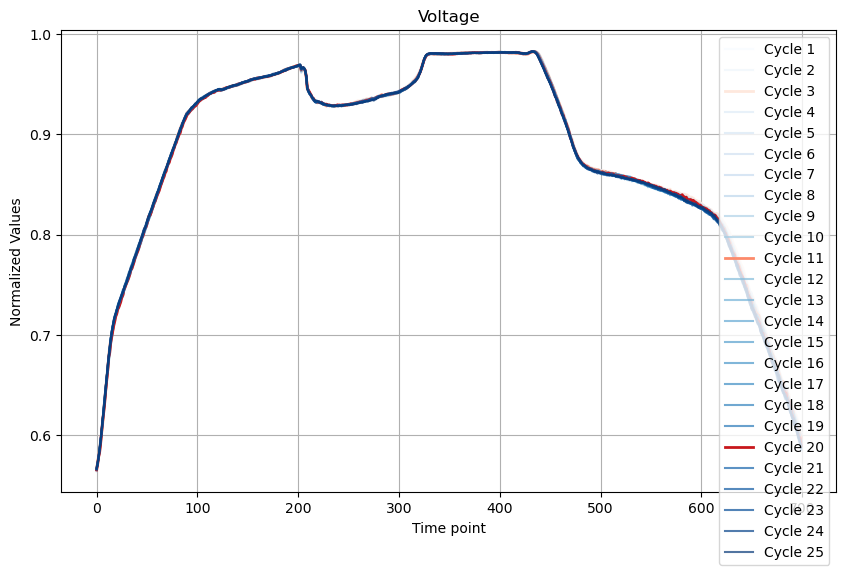

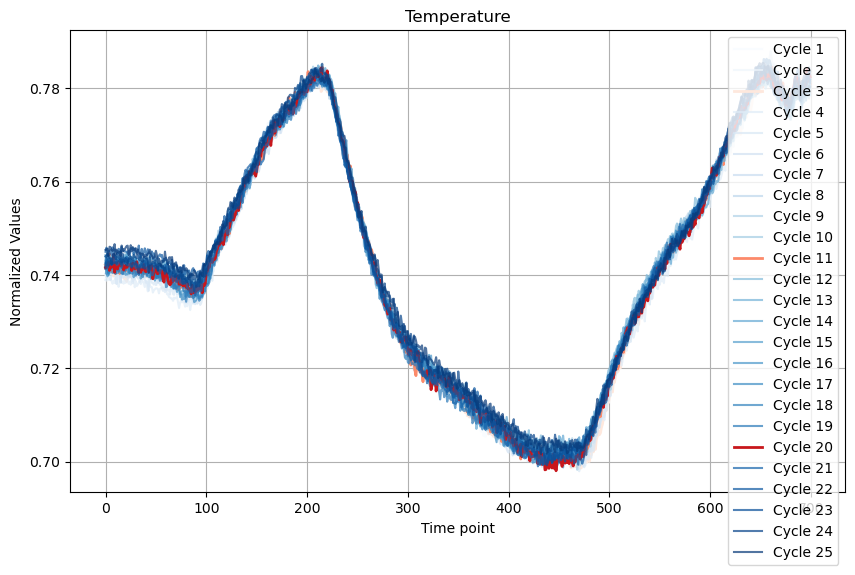

In [38]:
highlight_cycles = [20,11,3]
data=decoded_v[0]
cmap = plt.cm.Blues
cmap2 = plt.cm.Reds
j=0
features=["Current","Voltage","Temperature"]
# Iterate over features
for feature_index in range(data.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.title(str(features[j]))
    colors = [cmap(i / data.shape[0]) for i in range(data.shape[0])]
    colors2 = [cmap2(i / data.shape[0]) for i in range(data.shape[0])]
    j+=1
    # Iterate over cycles
    for cycle_index in range(data.shape[0]):
        if cycle_index+1 in highlight_cycles:
            plt.plot(data[cycle_index, feature_index][0:700], label=f'Cycle {cycle_index + 1}',color=colors2[cycle_index],linewidth=2)
        else:
            plt.plot(data[cycle_index, feature_index][0:700], alpha=0.7, color=colors[cycle_index],label=f'Cycle {cycle_index + 1}')
    
    plt.xlabel('Time point')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
model=model_bilstm
earlya=[]
latesta=[]
intermedaitea=[]

earlys=[]
latests=[]
intermedaites=[]

earlyp=[]
latestp=[]
intermedaitep=[]
for c in range(len(cells)):
    x,y=prepare_data_2(cells[c],25) # to be changed to prepare_data
    index2=int(len(x)/3)
    index3=len(x)-index2
    yt=np.array(cells[c]["SOH"])
    yt=pad_sequences(np.reshape(yt,(1,len(yt))),maxlen=2000,padding = 'post',dtype='float32')
    yt=yt[0]
    y1=model.predict(np.reshape(x[0],(1,25,3000)),verbose=0)[0] #to be changed to (25,64)
 
    y2=model.predict(np.reshape(x[index2],(1,25,3000)),verbose=0)[0] #to be changed to (25,64)
    
    y3=model.predict(np.reshape(x[index3],(1,25,3000)),verbose=0)[0] #to be changed to (25,64)
    
    input_step=index2*25+25
    index=range(input_step-25,input_step)
    index2=index[-1]+1
    
    input_step=index3*25+25
    index=range(input_step-25,input_step)
    index3=index[-1]+1
    
    yt=pad_sequences(np.reshape(yt,(1,len(yt))),maxlen=2000,padding = 'post',dtype='float32')
    yt=yt[0]
    earlya.append(masked_mae_loss(yt[24:],y1[0:len(y1)-24]))
    intermedaitea.append(masked_mae_loss(yt[index2:],y2[0:len(y2)-index2]))
    latesta.append(masked_mae_loss(yt[index3:],y3[0:len(y3)-index3]))
    
    earlys.append(masked_mse_loss(yt[24:],y1[0:len(y1)-24]))
    intermedaites.append(masked_mse_loss(yt[index2:],y2[0:len(y2)-index2]))
    latests.append(masked_mse_loss(yt[index3:],y3[0:len(y3)-index3]))
    
    earlyp.append(masked_mape_loss(yt[24:],y1[0:len(y1)-24]))
    intermedaitep.append(masked_mape_loss(yt[index2:],y2[0:len(y2)-index2]))
    latestp.append(masked_mape_loss(yt[index3:],y3[0:len(y3)-index3]))

print("early mape:",np.mean(earlyp))
print("intermediate mape:",np.mean(intermedaitep)) 
print("latest mape :",np.mean(latestp)) 
    
print("early mae:",np.mean(earlya)) 
print("early mse:",np.mean(earlys))  

print("intermediate mae:",np.mean(intermedaitea)) 
print("intermediate mse:",np.mean(intermedaites))   

print("latest mae :",np.mean(latesta)) 
print("latest mse :",np.mean(latests))

print("early mape std:",np.std(earlyp))
print("intermediate mape std:",np.std(intermedaitep))
print("latest mape std:",np.std(latestp)) 

print("early mae std:",np.std(earlya)) 
print("early mse std:",np.std(earlys))  

print("intermediate mae std:",np.std(intermedaitea)) 
print("intermediate mse std:",np.std(intermedaites))   

print("latest mae std:",np.std(latesta)) 
print("latest mse std:",np.std(latests)) 
    